In [1]:
# Conditional multimodal Variational Autoencoder (VAE) model to generate 3D brain MRI

In [2]:
import os
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import random

import monai
from monai.data import ImageDataset, DataLoader
from monai.transforms import Compose, RandFlip, Resize, ScaleIntensity, ToTensor, CenterSpatialCrop

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
Axes3D
n_neighbors = 10
n_components = 2
from sklearn import manifold
from sklearn.manifold import TSNE
import matplotlib.cm as cm


In [3]:
# random seed for reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

In [4]:
# Hyperparameters
channel = 1
feature = 16
latent_z= 32

learning_rate = 0.001
batch_size = 64
num_epochs = 101
beta = 1
num_classes = 16
k = 50 # save at k epochs

In [5]:
# Device
device = torch.device("cuda:0" if (torch.cuda.is_available() and args.ngpu > 0) else "cpu")

In [6]:
# path to data
data_dir_train = 'BraTS2021_3D16.npz'

In [7]:
#Load Training and Testing Data
def Data(dir):
    data_load = np.load(dir,allow_pickle=True)
    data = np.array(data_load['data'])
    
    return data[:12],data[12:]


In [8]:
# Get training and test data
train_data, test_data = Data(data_dir_train)

In [9]:
# Data Loader
class MyDataset(Dataset):
    def __init__(self,data,transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        imgs = self.data[index]
        x0 = imgs[0]
        x1 = imgs[1]
        label = imgs[2]

        if x0.max() != 0:
          x0 = x0.astype('float32').reshape((1, 240, 240, 155))
          x1 = x1.astype('float32').reshape((1, 240, 240, 155))

        if self.transform is not None:
          return self.transform(x0), self.transform(x1), label
  
      
    def __len__(self):
        return len(self.data)

In [10]:
# Apply some data augmentation [transformation] - train
transform_A = Compose([
                        CenterSpatialCrop((180, 180, 180)),
                        Resize((128,128,128)),
                        ScaleIntensity(),
                        RandFlip(prob=0.2, spatial_axis=None)
                        ])

In [11]:
# Apply some data augmentation [transformation] -test
transform_test = Compose([
                        CenterSpatialCrop((180, 180, 180)),
                        Resize((128,128,128)),
                        ])

In [12]:
# train data
print("Size of the data:",len(train_data))
dataset_train = MyDataset(train_data, transform=transform_A)
train_x = DataLoader(dataset_train, batch_size=batch_size,shuffle=True)

Size of the data: 12


In [13]:
# train data
print("Size of the data:",len(train_data))
dataset_train = MyDataset(train_data, transform=transform_test)
test_x = DataLoader(dataset_train, batch_size=batch_size,shuffle=False)

Size of the data: 12


In [14]:
# Plot T-sne distribution
def plot_Tsne_simple(data, label=0):
    tsne = manifold.TSNE(n_components=2,n_iter=1000,perplexity=5,init='pca')   
    data_fit = tsne.fit_transform(data)
    
    plt.figure()
    
    #for i in range(0,len(data_fit)):
    #    plt.text(data_fit[i,0], data_fit[i,1],s=label[i])
    plt.scatter(data_fit[:,0], data_fit[:,1],c=label)
    plt.title("t-SNE")
    plt.colorbar()
    plt.grid()
    plt.show()

In [15]:
def plot_PCA_simple(data, label=0):
    pca = PCA(n_components=2)
    pca.fit(data)
    data_fit = pca.transform(data)
    print(np.sum(pca.explained_variance_ratio_))

    plt.figure()
    
    #for i in range(0,len(data_fit)):
    #    plt.text(data_fit[i,0], data_fit[i,1],s=label[i])
    plt.scatter(data_fit[:,0], data_fit[:,1],c=label)
    plt.xlabel("First principal component",fontsize=8)
    plt.ylabel("Second principal component",fontsize=8)
    plt.title("PCA")
    plt.grid()
    plt.colorbar()
    plt.show()

In [16]:
# train data
print("Size of the data:",len(train_data))
dataset_train = MyDataset(train_data, transform=transform_A)
train_x = DataLoader(dataset_train, batch_size=batch_size,shuffle=True)


Size of the data: 12


In [17]:
# reconstruction loss
def reconstruction_loss(x, x_recon):
    recon_loss = nn.MSELoss(size_average=None, reduction="mean")

    return recon_loss(x_recon, x)

In [18]:
# kl divergence
def kl_divergence(mu, logvar):
    latent_kl = 0.5 * (-1 - logvar + mu.pow(2) + logvar.exp()).mean(dim=0)
    total_kld = latent_kl.sum()

    return total_kld

In [19]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

In [20]:

# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    #if classname.find('Conv')!= -1:
    #   nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d)or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
#

In [22]:
# Encoder Network
class EncoderNetwork(nn.Module):
    def __init__(self, channel,features,latent_z):
        super(EncoderNetwork, self).__init__()
        self.channel = channel
        self.features = features
        self.latent_z = latent_z
        
        self.conv1 = nn.Conv3d(self.channel, self.features, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv3d(self.features, self.features*2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv3d(self.features*2, self.features*3, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv3d(self.features*3, self.features*4, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv3d(self.features*4, self.features*5, 4, 2, 1, bias=False)
        self.conv6 = nn.Conv3d(self.features*5, self.features*6, 4, 4, 0, bias=False)

        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm3d(self.features)
        self.bn2 = nn.BatchNorm3d(self.features*2)
        self.bn3 = nn.BatchNorm3d(self.features*3)
        self.bn4 = nn.BatchNorm3d(self.features*4)
        self.bn5 = nn.BatchNorm3d(self.features*5)
        self.bn6 = nn.BatchNorm3d(self.features*6)
        
    def forward(self,x,c):
        x = self.relu(self.bn1(self.conv1(x))) # 128
        x = self.relu(self.bn2(self.conv2(x))) # 64
        x = self.relu(self.bn3(self.conv3(x))) # 32
        x = self.relu(self.bn4(self.conv4(x))) # 16
        x = self.relu(self.bn5(self.conv5(x))) # 8
        x = self.relu(self.bn6(self.conv6(x))) # 4
        x = x.view(x.shape[0], -1)

        return x

In [23]:
# Bottleneck layer
class MLP(nn.Module):
    def __init__(self,features,latent_z):
        super(MLP, self).__init__()
        self.features = features
        self.latent_z = latent_z

        self.linear = nn.Linear(6*self.features*1*1*1, self.features)
        self.mu = nn.Linear(self.features,self.latent_z)
        self.logvar = nn.Linear(self.features,self.latent_z)
        
    def forward(self, x):
        x = self.linear(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        
        return mu, logvar


In [24]:
# Decoder Network
class DecoderNetwork(nn.Module):
    def __init__(self,channel,features,latent_z):
        super(DecoderNetwork, self).__init__()
        self.channel = channel
        self.features = features
        self.latent_z = latent_z
        
        self.linear = nn.Linear(self.latent_z+16, self.features*2*2*2, bias=False) 

        self.convT1  = nn.ConvTranspose3d(self.features, self.features*6, 4, 2, 1, bias=False) # 4
        self.convT2  = nn.ConvTranspose3d(self.features*6, self.features*5, 4, 2, 1, bias=False) # 8
        self.convT3  = nn.ConvTranspose3d(self.features*5, self.features*4, 4, 2, 1, bias=False) # 16
        self.convT4  = nn.ConvTranspose3d(self.features*4, self.features*3, 4, 2, 1, bias=False) # 32
        self.convT5  = nn.ConvTranspose3d(self.features*3, self.features*2, 4, 2, 1, bias=False)  # 64
        #self.convT6  = nn.ConvTranspose3d(self.features, self.features, 4, 2, 1, bias=False)  # 128
        self.convT7  = nn.ConvTranspose3d(self.features*2, self.channel, 4, 2, 1, bias=False) # 256
        
        self.bn6 = nn.BatchNorm3d(self.features*6)  
        self.bn5 = nn.BatchNorm3d(self.features*5)
        self.bn4 = nn.BatchNorm3d(self.features*4)  
        self.bn3 = nn.BatchNorm3d(self.features*3)
        self.bn2 = nn.BatchNorm3d(self.features*2)
        self.bn1 = nn.BatchNorm3d(self.features)

        self.tanh = nn.Tanh()
        self.relu = nn.LeakyReLU(0.2, inplace=True)
      
        
    def forward(self,x,c):
        x = torch.cat([x,c], dim=1)
        x = self.relu(self.linear(x))
        x = x.view(x.shape[0], -1, 2,2,2)
        x = self.relu(self.bn6(self.convT1(x)))
        x = self.relu(self.bn5(self.convT2(x)))
        x = self.relu(self.bn4(self.convT3(x)))
        x = self.relu(self.bn3(self.convT4(x)))
        x = self.relu(self.bn2(self.convT5(x)))
        #x = self.relu(self.bn(self.convT6(x)))
        # Sigmoid activation for final conv layer
        x = self.tanh(self.convT7(x))
        
        return x

In [25]:
# Model
class Net(nn.Module):
    def __init__(self,channel,features,latent_z):
        super(Net,self).__init__()
        self.encoder = EncoderNetwork(channel,features,latent_z)
        self.decoder = DecoderNetwork(channel,features,latent_z)
        self.MLP = MLP(features,latent_z)
        self.latent_z   = latent_z
        
    def forward(self, x,c):
        distributions = self.encoder(x,c)
        # mean and Standard variation
        mu,logvar = self.MLP(distributions)

        # Botleneck, latent code
        z = reparameterize(mu, logvar)
        x_recons = self.decoder(z,c)

        return x_recons, mu, logvar, z


In [26]:
# Initialize the model
model = Net(channel,feature,latent_z).to(device)
model.apply(weights_init)
model = nn.DataParallel(model)
#print(model)

In [27]:
# optimization
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,betas=(0.5, 0.99),weight_decay=2.5e-5)
# criterion
criterion = nn.MSELoss().to(device) 

Starting looping for  101  epochs
Epoch: 0|101, Loss: 13.2082
Epoch: 1|101, Loss: 24.2166
Epoch: 2|101, Loss: 13.5786
Epoch: 3|101, Loss: 10.1163
Epoch: 4|101, Loss: 10.6586
Epoch: 5|101, Loss: 6.1334
Epoch: 6|101, Loss: 3.9585
Epoch: 7|101, Loss: 2.5121
Epoch: 8|101, Loss: 2.1466
Epoch: 9|101, Loss: 1.8260
Epoch: 10|101, Loss: 1.4744
Epoch: 11|101, Loss: 1.6287
Epoch: 12|101, Loss: 1.4263
Epoch: 13|101, Loss: 1.5067
Epoch: 14|101, Loss: 0.9857
Epoch: 15|101, Loss: 1.1359
Epoch: 16|101, Loss: 1.3481
Epoch: 17|101, Loss: 1.0929
Epoch: 18|101, Loss: 1.1229
Epoch: 19|101, Loss: 1.0589
Epoch: 20|101, Loss: 0.8606
Epoch: 21|101, Loss: 0.6856
Epoch: 22|101, Loss: 0.6809
Epoch: 23|101, Loss: 0.9293
Epoch: 24|101, Loss: 0.6174
Epoch: 25|101, Loss: 0.6215
Epoch: 26|101, Loss: 0.5570
Epoch: 27|101, Loss: 0.4412
Epoch: 28|101, Loss: 0.7463
Epoch: 29|101, Loss: 0.5406
Epoch: 30|101, Loss: 0.6652
Epoch: 31|101, Loss: 0.4464
Epoch: 32|101, Loss: 0.4807
Epoch: 33|101, Loss: 0.4576
Epoch: 34|101, Loss

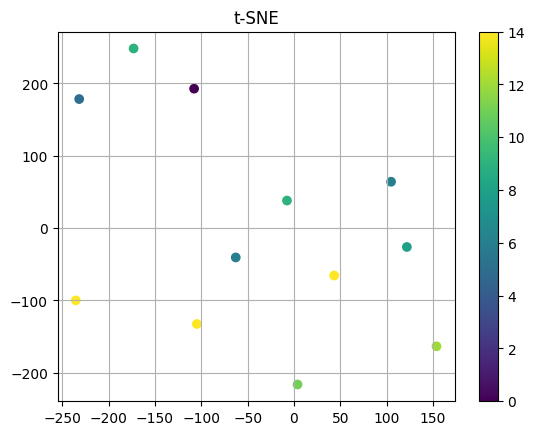

0.38899416


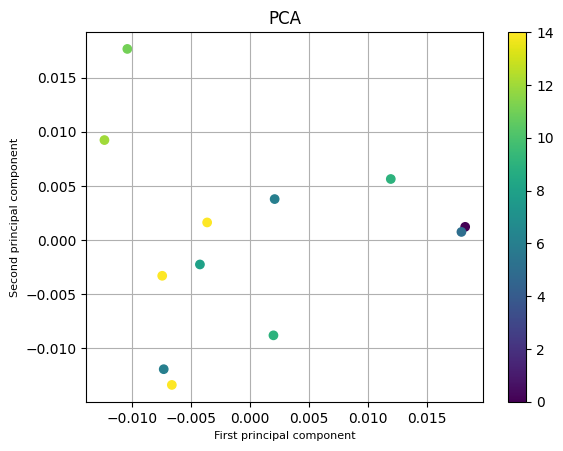

Epoch: 51|101, Loss: 0.4936
Epoch: 52|101, Loss: 0.3587
Epoch: 53|101, Loss: 0.3295
Epoch: 54|101, Loss: 0.3244
Epoch: 55|101, Loss: 0.3444
Epoch: 56|101, Loss: 0.2967
Epoch: 57|101, Loss: 0.3065
Epoch: 58|101, Loss: 0.2882
Epoch: 59|101, Loss: 0.3445
Epoch: 60|101, Loss: 0.5026
Epoch: 61|101, Loss: 0.4307
Epoch: 62|101, Loss: 0.3324
Epoch: 63|101, Loss: 0.3616
Epoch: 64|101, Loss: 0.2948
Epoch: 65|101, Loss: 0.2429
Epoch: 66|101, Loss: 0.2148
Epoch: 67|101, Loss: 0.2353
Epoch: 68|101, Loss: 0.2471
Epoch: 69|101, Loss: 0.2196
Epoch: 70|101, Loss: 0.2855
Epoch: 71|101, Loss: 0.2614
Epoch: 72|101, Loss: 0.3240
Epoch: 73|101, Loss: 0.3814
Epoch: 74|101, Loss: 0.2703
Epoch: 75|101, Loss: 0.2819
Epoch: 76|101, Loss: 0.1582
Epoch: 77|101, Loss: 0.1954
Epoch: 78|101, Loss: 0.1722
Epoch: 79|101, Loss: 0.1460
Epoch: 80|101, Loss: 0.2471
Epoch: 81|101, Loss: 0.1764
Epoch: 82|101, Loss: 0.1253
Epoch: 83|101, Loss: 0.1450
Epoch: 84|101, Loss: 0.1710
Epoch: 85|101, Loss: 0.1683
Epoch: 86|101, Loss:

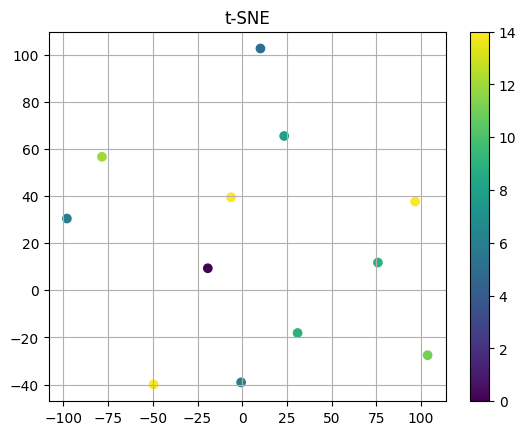

0.38448936


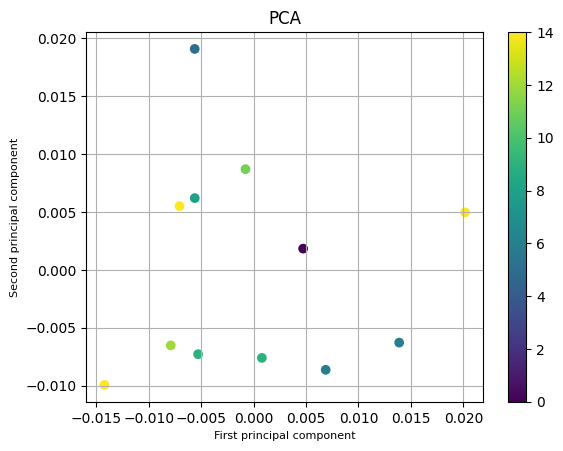

In [28]:
# Training loop
outputs = []
total_loss = []
save_latent = []

print("Starting looping for ",num_epochs," epochs")
for epoch in range(num_epochs):
    for i, data in enumerate(train_x):
        optimizer.zero_grad()

        #input 
        x = data[0].to(device)
        x1 = data[1].to(device, dtype=torch.float32)
        c = data[2].to(device, dtype=torch.float32)
        c1 = torch.nn.functional.one_hot(c.long(),num_classes).float()

        # model output
        recons, mu, logvar, z = model(x,c1) 
        
        # reconstructed images # kl divergence # loss 0
        recons_loss = reconstruction_loss(x,recons)
        total_kld = kl_divergence(mu, logvar)
        loss = recons_loss + beta*total_kld
        total_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch}|{num_epochs}, Loss: {loss.item():.4f}')

    # plot at k epochs
    if (epoch % k == 0 and epoch > 0):
        x_latent = (z/255.0).reshape(z.shape[0], -1)
        outputs.append((epoch,x,recons,c,x_latent))

        # Plot TSNE
        plot_Tsne_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())

        # Plot PCA
        plot_PCA_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())



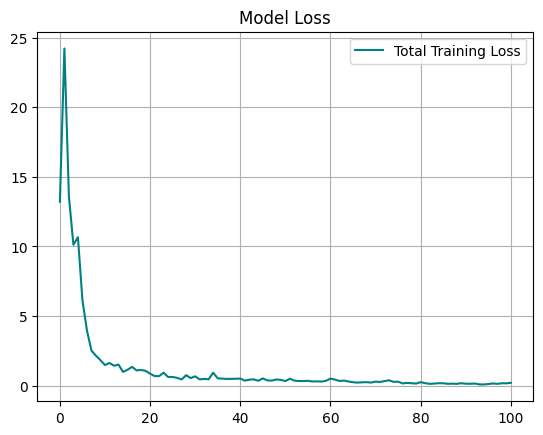

<Figure size 640x480 with 0 Axes>

In [29]:
# Plot total model loss
plt.plot(total_loss, label="Total Training Loss", color='teal')
plt.legend()
plt.title("Model Loss")
plt.grid(True)
plt.show()
plt.clf()

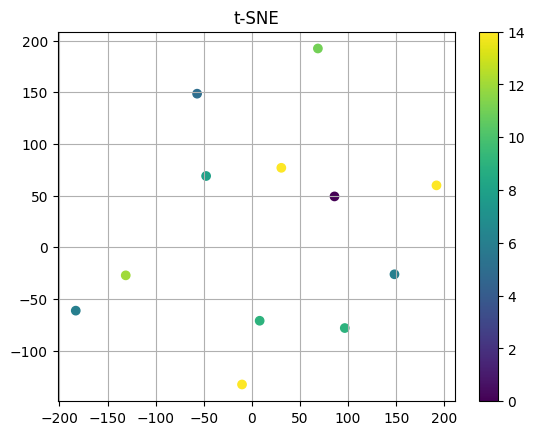

In [30]:
# plot latent space structure after training
plot_Tsne_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())

0.38448936


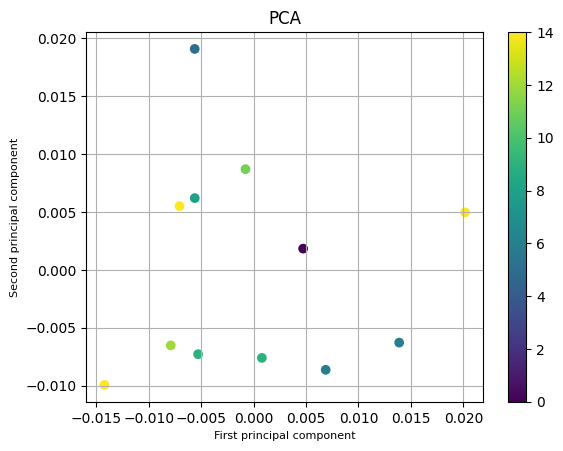

In [31]:
# plot latent space structure after training
plot_PCA_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())

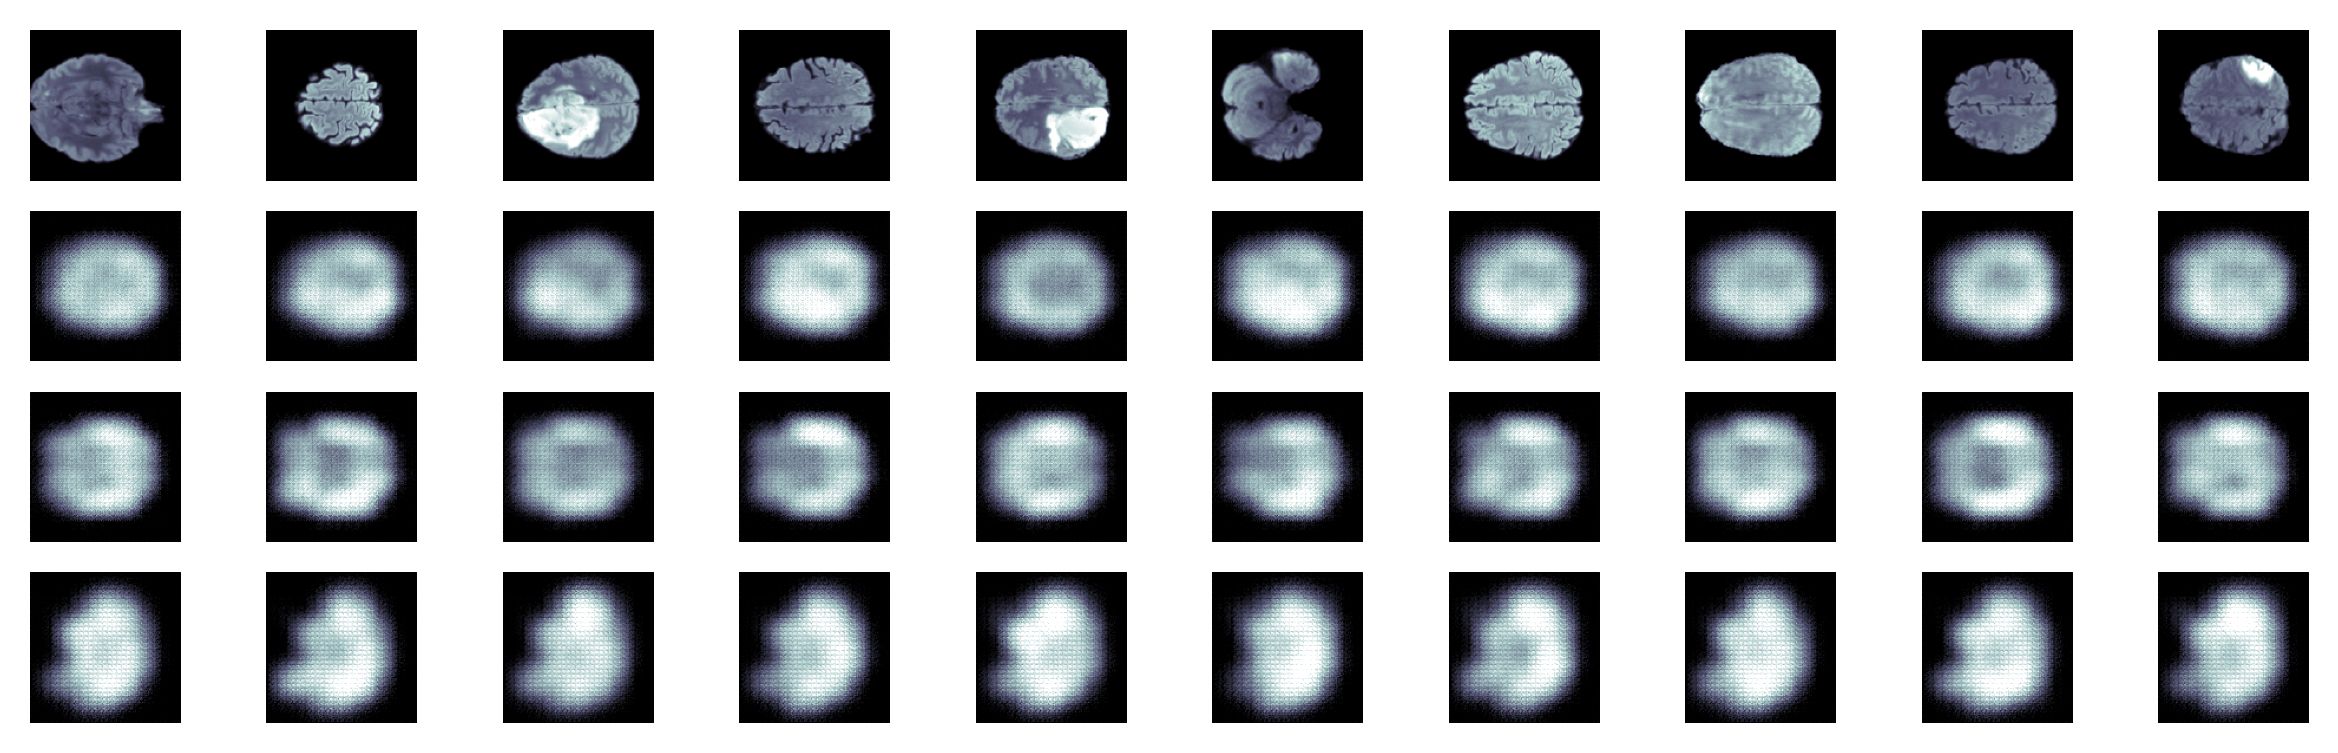

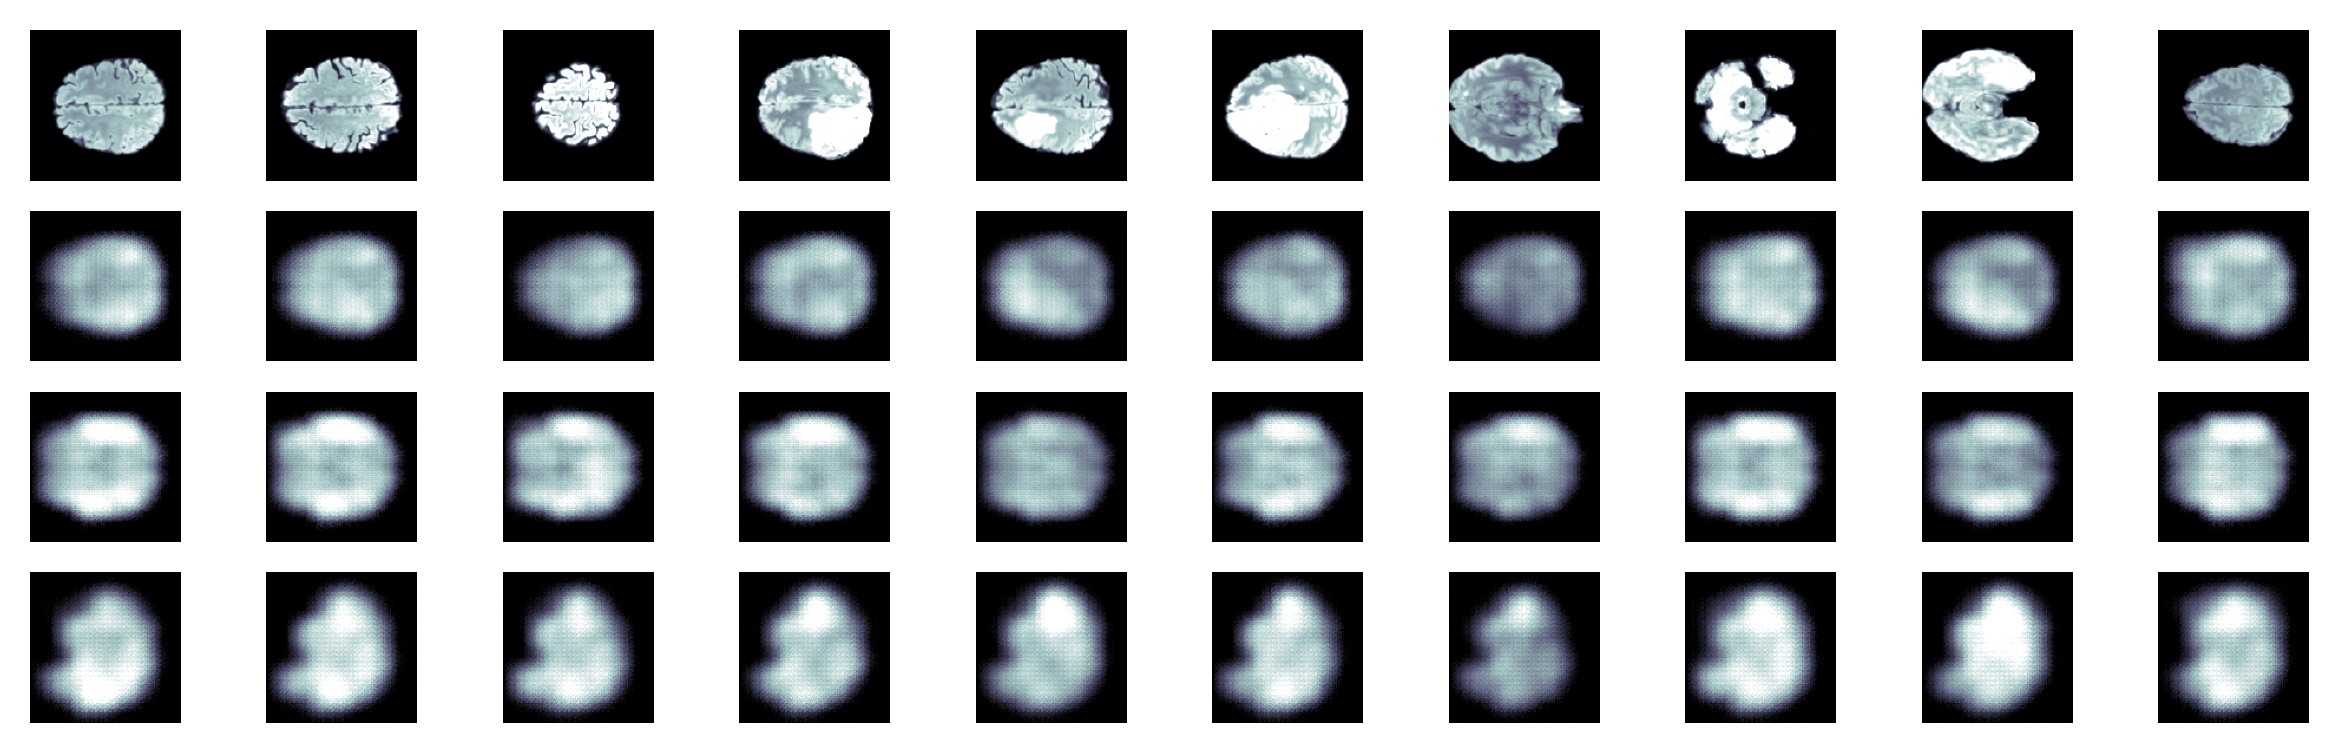

In [32]:
# Plot the Image and reconstructed one
start = 0
r = random.randint(50, 90)


for k in range(0, int(num_epochs/k)):
    plt.figure(figsize=(10, 3),dpi=300)
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recons = outputs[k][2].cpu().detach().numpy()
    
    for i, item1 in enumerate(imgs):
        if i >= 10: break
        plt.subplot(4, 10, i+1)
        plt.axis('off')
        stop = np.percentile(imgs[0].flatten(),99)
        plt.imshow(item1[0][:,:,r],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 10+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][:,:,r],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 20+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][:,r,:],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 30+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][r,:,:],cmap='bone', vmin=start, vmax=stop)
      

In [33]:
# z0
x_latent = (z/255.0).reshape(z.shape[0], -1)

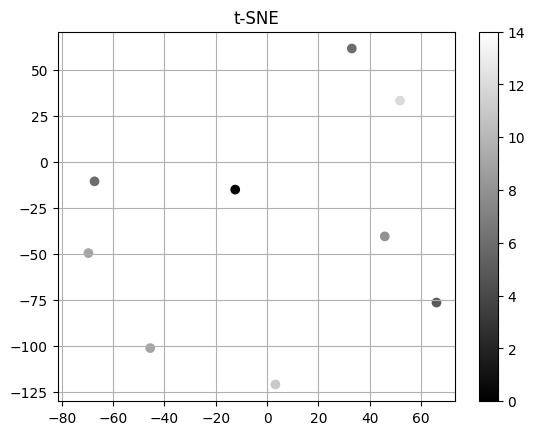

In [34]:
# Plot TSNE
plot_Tsne_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())

0.38448936


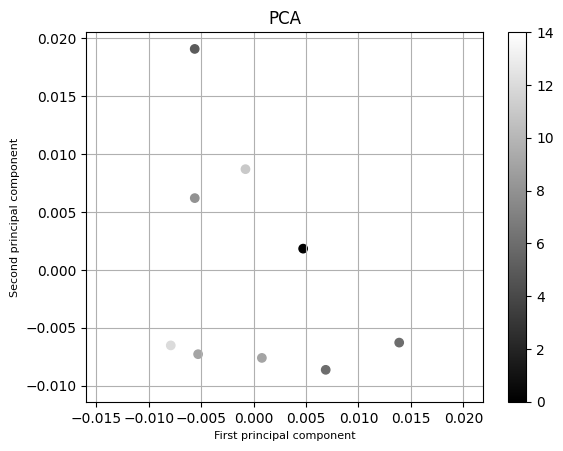

In [35]:
# Plot PCA
plot_PCA_simple(x_latent.cpu().detach().numpy(),c.cpu().detach().numpy())

In [36]:
# Testing
outputs_test = []
total_loss_test = []

with torch.no_grad():
    for i, data in enumerate(test_x):       
        #input 
        x = data[0].to(device)
        x1 = data[1].to(device, dtype=torch.float32)
        c = data[2].to(device, dtype=torch.float32)
        c1 = torch.nn.functional.one_hot(c.long(),num_classes).float()

        # model output
        recons, mu, logvar, z = model(x,c1) 

        # reconstrcuted images # kl divergence # loss 0
        recons_loss = reconstruction_loss(x,recons)
        total_kld = kl_divergence(mu, logvar)
        loss = recons_loss + beta*total_kld
        total_loss_test.append(loss.item())

    print(f'Epoch: {epoch+1}, Loss: {loss.item():.4f}')
    
    outputs_test.append((epoch, x, recons, c))

Epoch: 101, Loss: 376671.4062


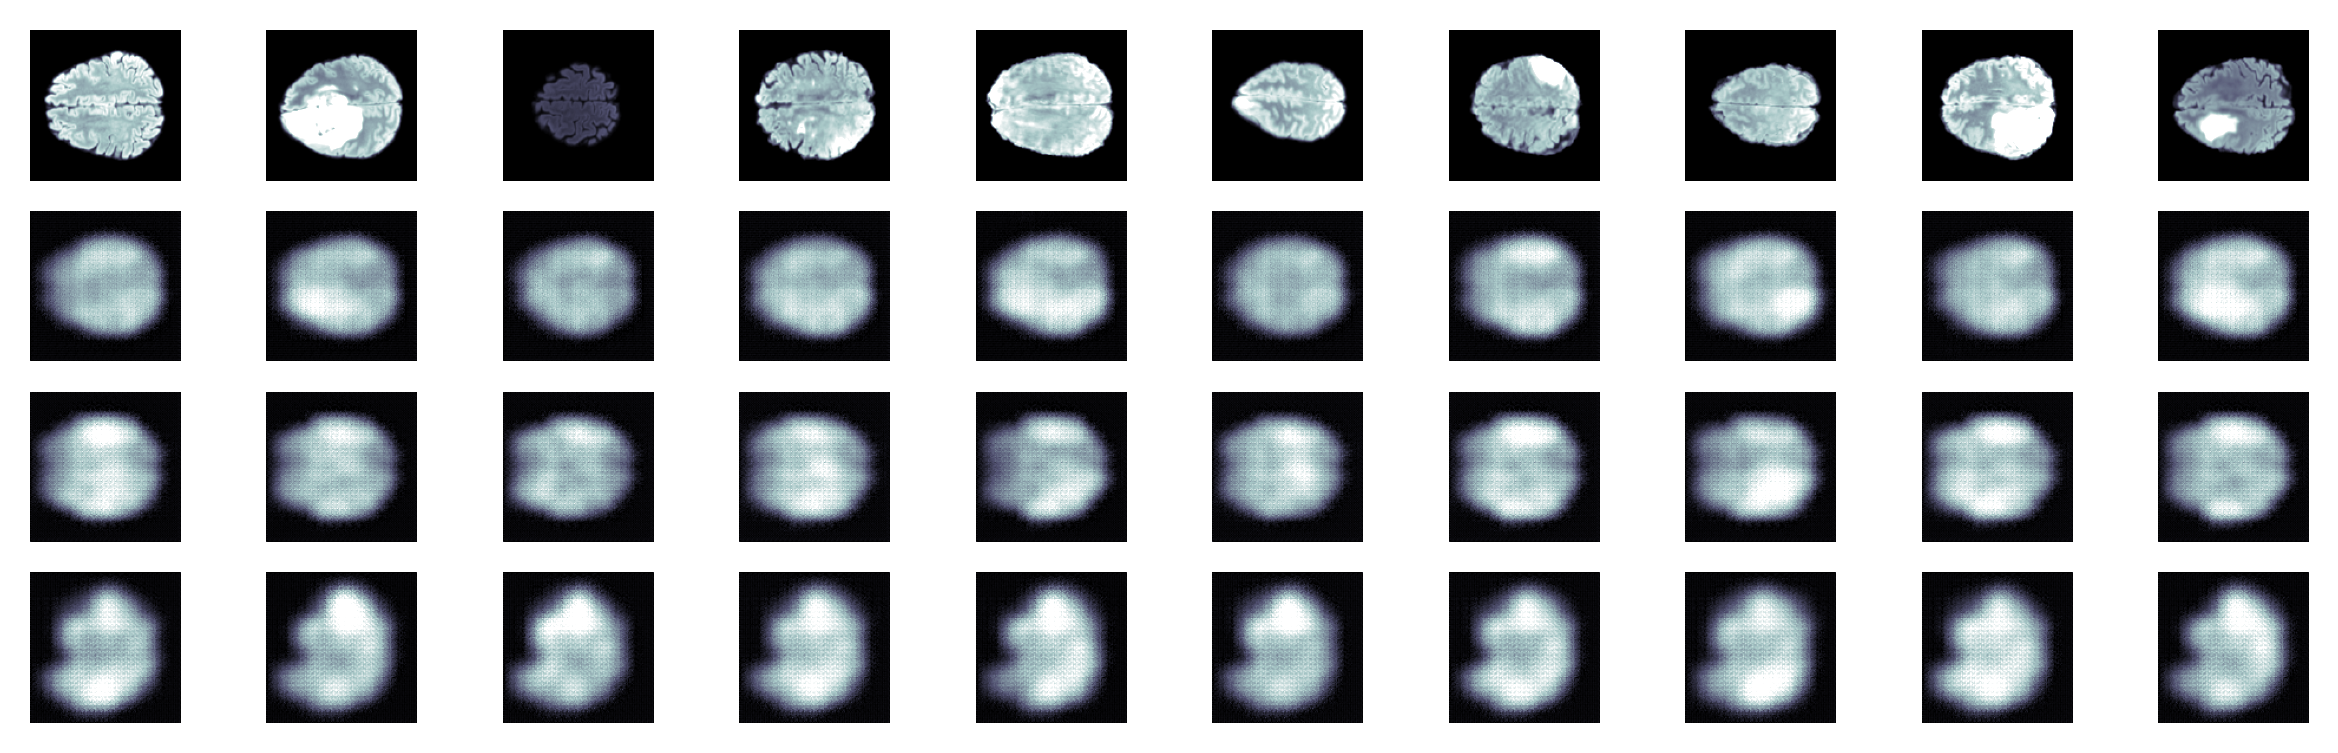

In [37]:
# Plot the Image and reconstructed one
for k in range(0, 1):
    plt.figure(figsize=(10, 3),dpi=300)
    plt.gray()
    imgs = outputs_test[k][1].cpu().detach().numpy()
    recons = outputs_test[k][2].cpu().detach().numpy()
    
    for i, item1 in enumerate(imgs):
        if i >= 10: break
        plt.subplot(4, 10, i+1)
        plt.axis('off')
        stop = np.percentile(imgs[0].flatten(),99)
        plt.imshow(item1[0][:,:,r],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 10+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][:,:,r],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 20+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][:,r,:],cmap='bone', vmin=start, vmax=stop)
    
    for i, item2 in enumerate(recons):
        if i >= 10: break
        plt.subplot(4, 10, 30+i+1)
        plt.axis('off')
        stop = np.percentile(item2[0].flatten(),99)
        plt.imshow(item2[0][r,:,:],cmap='bone', vmin=start, vmax=stop)
      

In [38]:
#